In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from scipy.spatial.transform import Rotation as R

from collections import defaultdict

from IPython.core.debugger import set_trace

SEED = 22
plt.rcParams['font.size'] = 20

In [17]:
def cosine_similarity(X,Y, only_diag=False):
    
    '''
    X - [T,d]
    Y - [T,d]
    '''
    X = X / np.linalg.norm(X,axis=-1)[:,None]
    Y = Y / np.linalg.norm(Y,axis=-1)[:,None]
    
    if only_diag:
        return (X*Y).sum(1).mean(0)
    else:
        return X@Y.T # [T,T]


# Data

In [3]:
T = 50
time = np.arange(T)

n_pc = 2 # principal components
n_rc = 3-n_pc # redundant components
dim = 3

I = np.stack(np.meshgrid(*[np.linspace(0,1,len(time)) for _ in range(n_pc)])) # fill x\xy\xyz plane
if n_rc > 0:
    I = np.concatenate([I] + [np.zeros((1,*I.shape[1:])) for _ in range(n_rc)], 0).reshape(3,-1)
    
I = I - I.mean(1)[:,None]

# rotation angles
α = np.pi/4 
β = np.pi/4
γ = np.pi/4

U = R.from_euler('xyz', [α, β, γ], degrees=False).as_matrix()

I_ = U@I
I_ /= I_.std(1,keepdims=True)

theta = np.concatenate([time for _ in range(len(time))])/T
theta -= theta.mean()

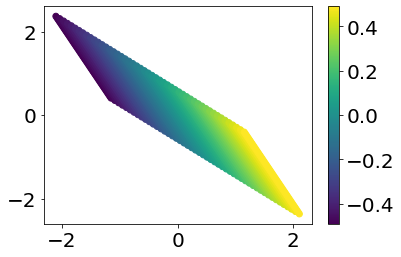

In [4]:
plt.scatter(I_[0], I_[2],c=theta)
plt.colorbar()

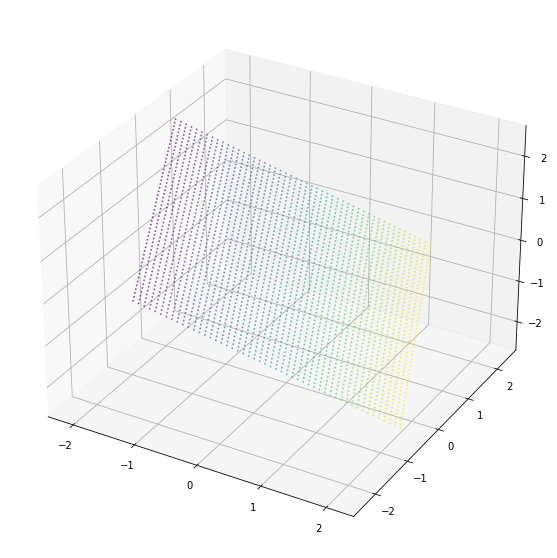

In [5]:
%matplotlib inline
plt.figure(figsize=(10,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(I_[0], 
             I_[1], 
             I_[2],
             s=1,
             c=theta,
             alpha=0.5)

plt.show()

In [6]:
def get_pca(I_, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(I_)
    v = pca.components_.T
    return v

In [7]:
def gs_orthogonalization(v):
    '''
    v: [d,N]
    '''
    d = v.shape[0]
    if d == 1:
        return v / np.linalg.norm(v,axis=1)[:,None]
    v = v.copy()
    u_0 = v[0] / np.linalg.norm(v[0])
    u_orth = [u_0]
    
    for i in range(1,d):
        u_i = v[i]
        for u in u_orth:
            u_i -= (v[i]@u)*u
        u_i = u_i / np.linalg.norm(u_i)
        u_orth.append(u_i)
        
    return np.stack(u_orth,0)

In [8]:
def grassman_distance(U,V):
    '''
    U - [k,N] - k'th N-dim base vectors
    V - [k,N] - k'th N-dim base vectors
    '''
    
    S = np.linalg.svd(U@V.T, compute_uv=False)
    return np.linalg.norm(np.arccos(np.clip(S,0,1)))

In [9]:
n_y = 2

In [10]:
N = I_.shape[1]
cov= I_@I_.T / (N-1)
_,v = np.linalg.eig(cov)
v = v[:,-n_y:].T
v_ = gs_orthogonalization(v)

pca = PCA(n_components=n_y)
Z_pca = pca.fit_transform(I_.T).T
v_pca = pca.components_
ev_pca = pca.explained_variance_.sum()

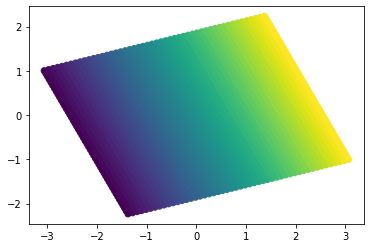

In [11]:
plt.scatter(Z_pca[0], Z_pca[1], c=theta)

In [12]:
grassman_distance(v_pca, v_)

0.0

In [13]:
b1 = np.array([[0,1,0], [1,0,0]])
b2 = np.array([[-1,0,0], [0,-1,0]])

grassman_distance(b1, b2)

0.0

# Matrix Oja rule

In [14]:
def train_oja(
    I,
    W,
    v_pca=None, # to compute Grassman distance
    η=1e-1, # learning rate
    tol=1e-1,
    max_epochs=1000,
    matrix_form=True
    ):
    
    grassman_distance = []
    ev_s = []
    
    n_timesteps = I.shape[1]
    n_y = W.shape[0]
    epoch = 0
    gdist = np.inf
    C = I@I.T / (n_timesteps-1)
    exit_condition = False
    
    while not exit_condition:
                
        if matrix_form:
            # oja rule update
            W += η*(W@C - (W@C)@(W.T@W))
            
            if v_pca is not None:
                gdist = grassman_distance(v_pca, W)
                grassman_distance.append(gdist)        
                
            Z_ = W@I # projection on found PC
            ev = Z_.var(1).sum() # explained variance
            ev_s.append(ev)
        else:
            for j in range(n_timesteps):
                # iterative version
                I_t = I[:,j:j+1]
                y_t = W@I_t
                W += η*(y_t@I_t.T - y_t@(y_t*W).sum(0, keepdims=True))
                
                gdist = grassman_distance(v_pca, W)
                Z_ = W@I # projection on found PC
                ev = Z_.var(1).sum() # explained variance
                losses.append(gdist)        
                ev_s.append(ev)
        
        exit_condition = gdist < tol and np.isclose(W@W.T, np.eye(n_y), atol=tol).all()

        epoch += 1
        if epoch > max_epochs and not exit_condition:
            print('Failed to converge!')
            break

    return W, Z_, grassman_distance, ev_s

In [15]:
W = np.random.randn(n_y, 3)*1e-3
W, Z_, losses, ev_s =  train_oja(I_,
                                W,
                                v_pca, # to compute Grassman distance
                                η = 1e-1, # learning rate
                                tol=1e-1,
                                max_epochs=10000,
                                matrix_form=False
                                )

NameError: name 'train_oja' is not defined

In [17]:
# plt.plot(ev_s)

In [18]:
# I_.var(1).sum()

In [19]:
# plt.scatter(Z_[0], Z_[1],c=theta)
# plt.colorbar()

In [20]:
# plt.plot(losses)

In [21]:
# (W@W.T).round(1)

# Overparametrized

In [19]:
# simplest example of I_
n_cycles = 1
I_ = np.concatenate([np.eye(10)]*n_cycles, axis=1)
I_ -= I_.mean(1,keepdims=True)
theta = np.concatenate([np.arange(10)/10]*n_cycles, axis=0)
theta -= theta.mean()

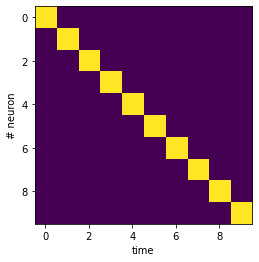

In [20]:
plt.imshow(I_)
plt.xlabel('time')
plt.ylabel('# neuron')
plt.show()

In [229]:
def train_regression(I, theta, W, W_out, η, f, max_epoch, r2_tol, synchronize=False):
    
    r2_scores = []
    losses = []
    n_timesteps = I.shape[1]
    train_finished = False
    
    W_0 = W.copy()
    W_out_0 = W_out.copy()
    
    for epoch in range(max_epoch):
        for j in range(n_timesteps):
            # iterative version
            I_t = I[:,j:j+1]
            x_t = f(W@I_t)
            theta_t = theta[None,j:j+1]
            
            W_update = x_t@I_t.T - x_t@(x_t*W).sum(0, keepdims=True)
            W_update /= np.linalg.norm(W_update)
            W += η*W_update
            
            # re-calculate for the new W
            if synchronize:
                x_t = f(W@I_t)
            theta_pred = W_out@x_t

            # delta rule
            delta = (theta_t - theta_pred)
            W_out_update = delta@x_t.T
            W_out_update /= np.linalg.norm(W_out_update)
            W_out += η*(W_out_update)
            
            y_pred = W_out@f(W@I)
            loss = (0.5*(theta - y_pred.flatten())**2).mean()
            r2 = r2_score(theta, y_pred.flatten())
            r2_scores.append(r2)
            losses.append(loss)
            
            if 1-r2 < r2_tol:
                train_finished=True
                break

        if train_finished:
            break
    
#     dW = W - W_0
#     dW_out = W_out - W_out_0
    
    return W_0, W_out_0, W, W_out, losses, r2_scores

In [205]:
def f(x):
    return np.tanh(x)

W = np.random.randn(200, I_.shape[0])*1e-3
W_out = np.random.randn(1, 200)*1e-3

η = 1e-2
r2_tol = 1e-2

max_epoch = 100000
W_0, W_out_0, W, W_out, losses, r2_scores = train_regression(I_, theta, W, W_out, η, f, max_epoch, r2_tol)

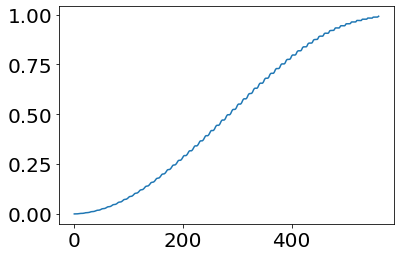

In [206]:
plt.plot(r2_scores)

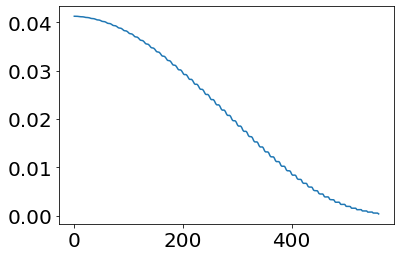

In [207]:
plt.plot(losses)

In [208]:
def loss_along_line(I, theta, W_0, W_out_0, W_1, W_out_1, f, num=100):
    '''
    line from [W_0, W_out_0] -> [W_1, W_out_1]
    '''
    losses = []
    for alpha in np.linspace(0,1, num=num):
        W = (1-alpha)*W_0 + (alpha)*W_1
        W_out = (1-alpha)*W_out_0 + (alpha)*W_out_1
        
        y_pred = W_out@f(W@I)
        loss = (0.5*(theta - y_pred.flatten())**2).mean()
        losses.append(loss)
        
    return losses

In [222]:
noise_magnitudes = [2e-1] #[1e-1, 2e-1, 4e-1, 6e-1, 8e-1, 1]

PV_s_list = defaultdict(list)
total_iter_list = defaultdict(list)
r2_scores_all = defaultdict(list)
switch_times = defaultdict(list)
line_losses = defaultdict(list)

plasticity_iters = 1000
max_epoch = 1 #100000
η = 5e-2

for noise_magnitude in noise_magnitudes:
    try:
        for _ in tqdm(range(plasticity_iters)):
            
            # add noise
            dW_noise = np.clip(np.random.randn(*W.shape), -1, 1)
            dW_noise = (dW_noise / np.linalg.norm(dW_noise))*noise_magnitude
            
            dW_out_noise = np.clip(np.random.randn(*W_out.shape), -1, 1)*noise_magnitude
            dW_out_noise = (dW_out_noise / np.linalg.norm(dW_out_noise))*noise_magnitude
            
            W += dW_noise
            W_out += dW_out_noise
            
            # train two-layer
            W_0, W_out_0, W, W_out, losses, r2_scores = train_regression(I_, 
                                                                         theta, 
                                                                         W, 
                                                                         W_out, 
                                                                         η, 
                                                                         f, 
                                                                         max_epoch, 
                                                                         r2_tol)
            
            line_loss = loss_along_line(I_, theta, W_0, W_out_0, W, W_out, f, num=100)
            
            PV_s_list[noise_magnitude].append(f(W@I_))
            total_iter_list[noise_magnitude].append(len(r2_scores))
            line_losses[noise_magnitude].append(line_loss)

            r2_scores_all[noise_magnitude] += r2_scores
            switch_times[noise_magnitude].append(len(r2_scores_all[noise_magnitude]))
    except:
        PV_s_list.pop(noise_magnitude)
        r2_scores_all.pop(noise_magnitude)
        switch_times.pop(noise_magnitude)
        total_iter_list.pop(noise_magnitude)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.52it/s]


In [223]:
r2_scores_all.keys() 

dict_keys([0.2])

In [224]:
# mean_niter = np.array(list(total_iter_list.values())).mean(1)
# std_niter = np.array(list(total_iter_list.values())).std(1)

# plt.plot(list(total_iter_list.keys()), mean_niter)
# plt.fill_between(list(total_iter_list.keys()), mean_niter-std_niter, mean_niter+std_niter, alpha=0.5)
# plt.xlabel('Noise magnitude')
# plt.ylabel('# Hebb iter ')
# plt.title('# Hebb iter till convergence')

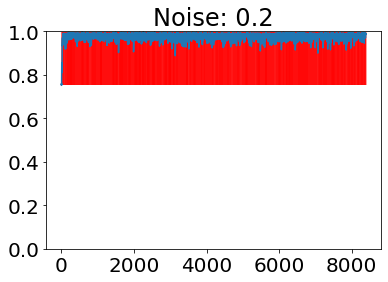

In [225]:
for noise_mag, r2_scores_  in r2_scores_all.items():
    plt.figure()
    plt.plot(r2_scores_)
    plt.vlines(switch_times[noise_mag], min(r2_scores_), max(r2_scores_),color='red',alpha=0.5)
    plt.title(f'Noise: {noise_mag}')
    plt.ylim(0,1)
    plt.show()

No handles with labels found to put in legend.


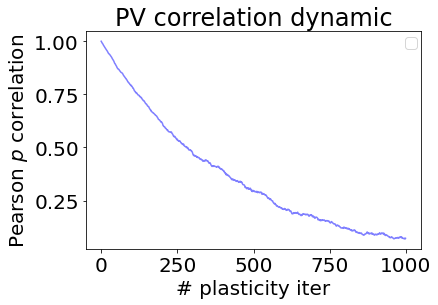

In [226]:
for noise_mag, PV_s in PV_s_list.items():

    plt.figure()
    pv_corr = []
    X_0 = PV_s[0] # trial
    for j in range(plasticity_iters):
        X_j = PV_s[j]
        pv_corr.append(cosine_similarity(X_0.T, X_j.T, only_diag=True))
    plt.plot(pv_corr, color='blue', alpha=0.5)

    plt.title(f'PV correlation dynamic')
    plt.xlabel('# plasticity iter')
    plt.ylabel(r'Pearson $p$ correlation')
    plt.legend(bbox_to_anchor=(1.01, 1.01),fontsize=15)
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

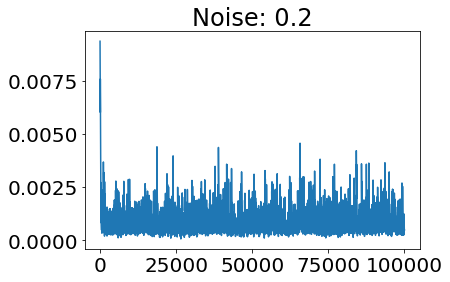

In [227]:
for noise_mag, line_loss  in line_losses.items():
    line_loss_cat = np.concatenate(line_loss)
    plt.figure()
    plt.plot(line_loss_cat)
#     plt.vlines(np.linspace, min(line_loss_cat), max(line_loss_cat),color='red',alpha=0.5)
    plt.title(f'Noise: {noise_mag}')
#     plt.ylim(0,1)
    plt.show()

In [34]:
def train_multilayer(I_, 
                     W_x,
                     W_y,
                     W_out, 
                     η_x=1e-1,
                     η_y=1e-1,
                     η_out=1e-2
                     ):
    
    ev_s_X = []
    ev_s_Y = []
    r2_scores = []

    n_timesteps = I.shape[1]
    
    for j in tqdm(range(n_timesteps)):

        # fist layer
        I_t = I_[:,j:j+1]
        x_t = W_x@I_t
        W_x += η_x*(x_t@I_t.T - x_t@(x_t*W_x).sum(0, keepdims=True))

        X_ = W_x@I_ # projection on found PC
        ev = X_.var(1).sum() # explained variance
        ev_s_X.append(ev)

        # second layer
        y_t = W_y@x_t
        W_y += η_y*(y_t@x_t.T - y_t@(y_t*W_y).sum(0, keepdims=True))

        Y_ = W_y@X_ # projection on found PC
        ev = Y_.var(1).sum() # explained variance
        ev_s_Y.append(ev)

        # predictions
        y_t = Y_[:,j:j+1]
        theta_t = theta[None,j:j+1]
        theta_pred = W_out@y_t
        delta = (theta_t - theta_pred)
        W_out += η_out*(delta@y_t.T) #  - wd*W_out

        y_pred = W_out@Y_
        r2_scores.append(r2_score(theta, y_pred.flatten()))
    
    return X_,Y_, y_pred, W_x, W_y, W_out, ev_s_X, ev_s_Y, r2_scores


In [35]:
# I_ = np.eye(10)
# theta = np.arange(10)/10
# theta -= theta.mean()

In [62]:
X_s = []
Y_s = []

W_x = np.random.randn(200, I_.shape[0])*1e-3
W_y = np.random.randn(10,200)*1e-3
W_out = np.random.randn(1,10)*1e-3

plasticity_iters = 10
noise_magnitude = 1e-1

for _ in range(plasticity_iters):

    out = train_multilayer(I_, 
                         W_x,
                         W_y,
                         W_out, 
                         η_x=1e-1,
                         η_y=1e-1,
                         η_out=1e-2
                         )

    X_,Y_, y_pred, W_x, W_y, W_out, ev_s_X, ev_s_Y, r2_scores = out
    
    X_s.append(X_)
    Y_s.append(Y_)

    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1,3,1)

    ax1.plot(ev_s_X)
    ax1.plot(ev_s_Y)
    ax1.hlines(ev_pca, 0, len(ev_s_X), color='red')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(Y_[0], Y_[1], c=theta)

    ax3 = plt.subplot(1,3,3)
    ax3.plot(r2_scores)

    W_x += np.clip(np.random.randn(*W_x.shape), -1, 1)*noise_magnitude
    W_y += np.clip(np.random.randn(*W_y.shape), -1, 1)*noise_magnitude
    W_out += np.clip(np.random.randn(*W_out.shape), -1, 1)*noise_magnitude

In [37]:
eucl_distance = []
X_0 = X_s[0] # trial
for j in range(plasticity_iters):
    X_j = X_s[j]
    eucl_distance.append(np.linalg.norm(X_0 - X_j, axis=0).mean())

In [39]:
eucl_distance = []
Y_0 = Y_s[0] # trial
for j in range(plasticity_iters):
    Y_j = Y_s[j]
    eucl_distance.append(np.linalg.norm(Y_0 - Y_j, axis=0).mean())

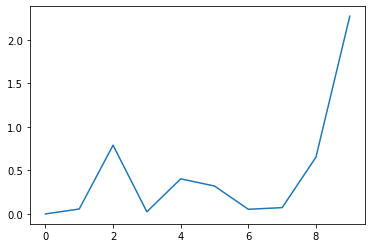

In [40]:
plt.plot(eucl_distance)

# Oja rule can adapt to the drifting input

  0%|                                                                                                                                                 | 0/10 [00:00<?, ?it/s]

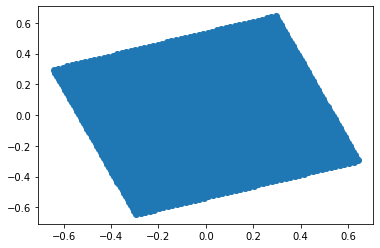

 10%|█████████████▋                                                                                                                           | 1/10 [00:00<00:06,  1.45it/s]

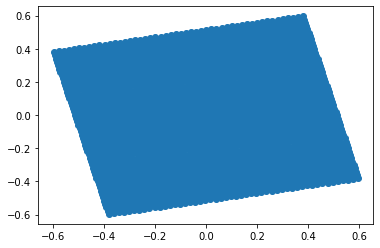

 20%|███████████████████████████▍                                                                                                             | 2/10 [00:01<00:05,  1.58it/s]

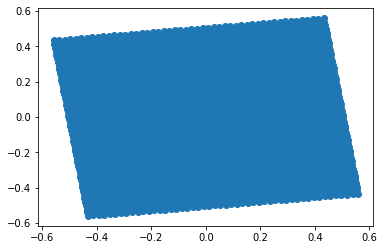

 30%|█████████████████████████████████████████                                                                                                | 3/10 [00:01<00:04,  1.52it/s]

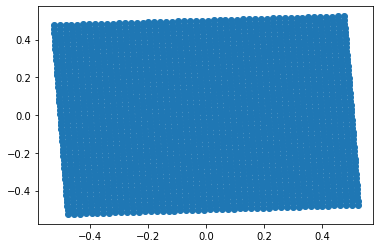

 40%|██████████████████████████████████████████████████████▊                                                                                  | 4/10 [00:02<00:03,  1.65it/s]

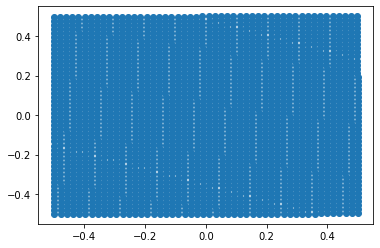

 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 5/10 [00:03<00:02,  1.75it/s]

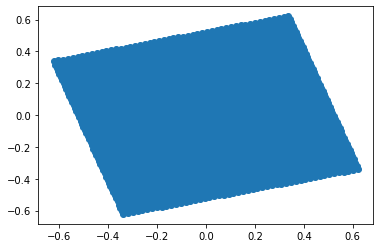

 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 6/10 [00:03<00:02,  1.81it/s]

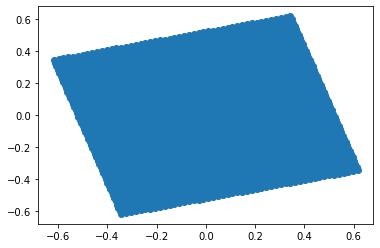

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7/10 [00:04<00:01,  1.84it/s]

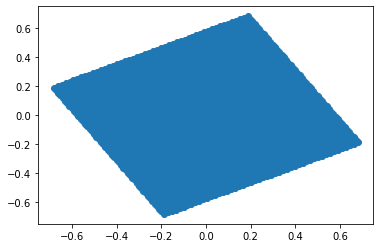

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8/10 [00:04<00:01,  1.87it/s]

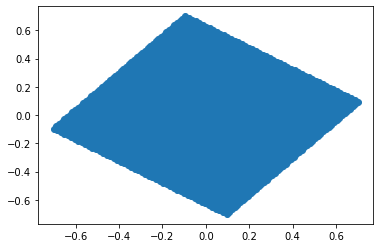

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9/10 [00:05<00:00,  1.70it/s]

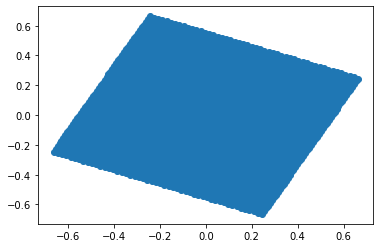

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


In [80]:
losses_all = []
ev_all = []
α_s, β_s, γ_s = [], [], []
switch_times = []

α,β,γ = 0,0,0
angle_magnitude= (np.pi/8)
W = np.random.randn(n_y,3)*1e-3

for i in tqdm(range(10)):
    
    # rotation angles
    α = α + np.random.ranf()*angle_magnitude
    β = β + np.random.ranf()*angle_magnitude
    γ = γ + np.random.ranf()*angle_magnitude
    
    α_s.append(α)
    β_s.append(β)
    γ_s.append(γ)
    
    U = R.from_euler('xyz', [α, β, γ], degrees=False).as_matrix()

    I_ = U@I
    
    # PCA
    pca = PCA(n_components=n_y)
    pca.fit(I_.T)
    v_pca = pca.components_
    
    W, Z_, losses, ev_s =  train_oja(I_,
                                    W,
                                    v_pca, # to compute Grassman distance
                                    η = 1e-1, # learning rate
                                    tol=1e-1,
                                    max_epochs=10000,
                                    matrix_form=False
                                    )
        
    losses_all += losses   
    ev_all += ev_s
            
    switch_times.append(len(losses_all))
    plt.figure()
    plt.scatter(Z_[0], Z_[1])
    plt.show()
            

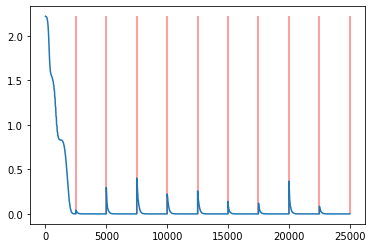

In [81]:
plt.plot(losses_all)
plt.vlines(switch_times, 0,max(losses_all),color='red',alpha=0.5)

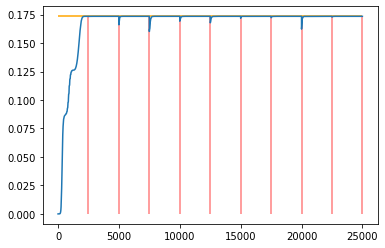

In [93]:
plt.plot(ev_all)
plt.vlines(switch_times, min(ev_all), ev_pca, color='red',alpha=0.5)
plt.hlines(ev_pca, 0, len(ev_all), color='orange')
plt.show()

# Regression 

In [142]:
y = W@I_
n_timesteps = y.shape[1]
r2_scores = []
η = 1e-1
wd = 9e-2
tol = 1e-1
max_epochs = 100

W_out = np.zeros_like(np.random.randn(1,n_y))

epoch = 0
exit_condition = False
while not exit_condition:
    for j in range(N):
        y_t = y[:,j:j+1]
        theta_t = theta[None,j:j+1]

        W_out += η*(theta_t@y_t.T - wd*W_out)

        y_pred = W_out@y
        r2_scores.append(r2_score(theta, y_pred.flatten()))
        exit_condition = 1-r2_scores[-1] < tol

    epoch += 1
    if epoch > max_epochs and not exit_condition:
        print('Failed to converge!')
        break
        

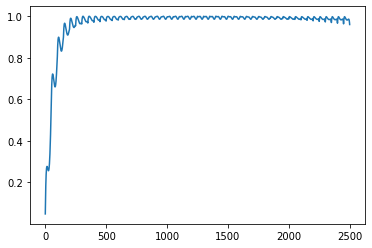

In [143]:
plt.plot(r2_scores)

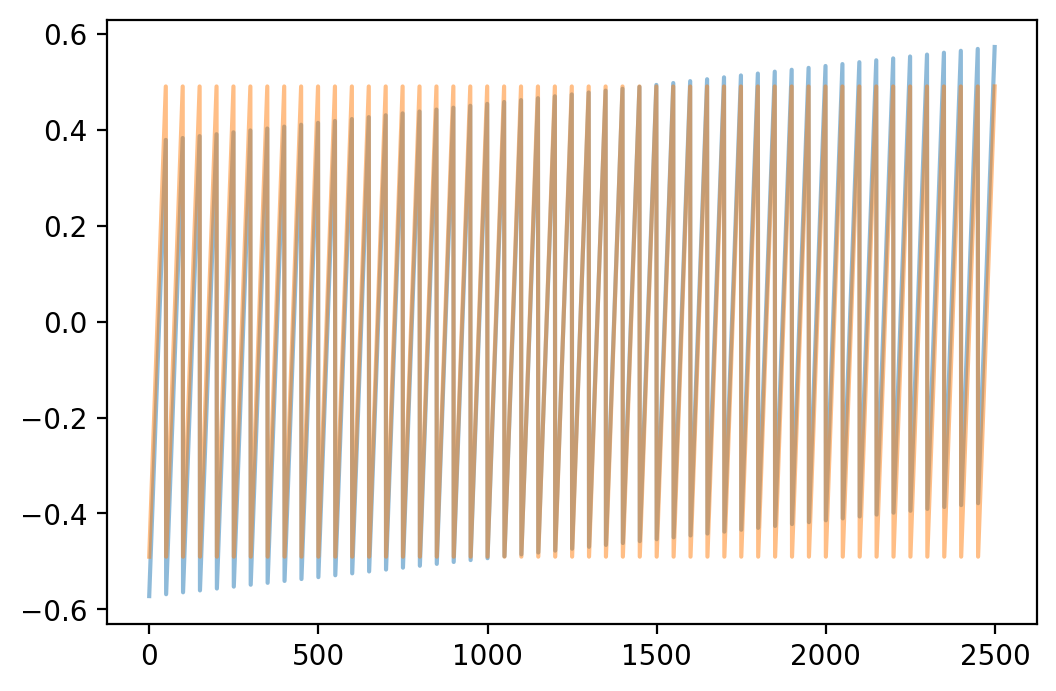

In [144]:
plt.figure(dpi=200)
plt.plot((W_out@(W@I_))[0], alpha=0.5)
plt.plot(theta, alpha=0.5)

In [147]:
def train_output(y,
                 theta,
                 η = 1e-1,
                 wd = 9e-2,
                 tol=1e-1,
                 max_epochs=1000):
    
    n_timesteps = y.shape[1]
    r2_scores = []
    
    W_out = np.zeros_like(np.random.randn(1,n_y))
    epoch = 0
    exit_condition = False
    while not exit_condition:
        for j in range(N):
            y_t = y[:,j:j+1]
            theta_t = theta[None,j:j+1]

            W_out += η*(theta_t@y_t.T - wd*W_out)

            y_pred = W_out@y
            r2_scores.append(r2_score(theta, y_pred.flatten()))
            exit_condition = 1-r2_scores[-1] < tol
            
            if exit_condition:
                break
            
        epoch += 1
        if epoch > max_epochs and not exit_condition:
            print('Failed to converge!')
            break

    return W_out, r2_scores

# Drifting input regression

In [151]:
losses_all = []
r2_scores_all = []
ev_all = []
α_s, β_s, γ_s = [], [], []
switch_times = []
switch_times_output = []

α,β,γ = 0,0,0
angle_magnitude= (np.pi/8)
W = np.random.randn(n_y,3)*1e-3

for i in tqdm(range(10)):
    
    # rotation angles
    α = α + np.random.ranf()*angle_magnitude
    β = β + np.random.ranf()*angle_magnitude
    γ = γ + np.random.ranf()*angle_magnitude
    
    α_s.append(α)
    β_s.append(β)
    γ_s.append(γ)
    
    U = R.from_euler('xyz', [α, β, γ], degrees=False).as_matrix()

    I_ = U@I
    
    # PCA
    pca = PCA(n_components=n_y)
    pca.fit(I_.T)
    v_pca = pca.components_
    
    W, Z_, losses, ev_s =  train_oja(I_,
                                    W,
                                    v_pca, # to compute Grassman distance
                                    η = 1e-1, # learning rate
                                    tol=1e-1,
                                    max_epochs=10000,
                                    matrix_form=False
                                    )
    y = W@I_
    W_out, r2_scores = train_output(y,
                                     theta,
                                     η = 1e-1,
                                     wd = 9e-2,
                                     tol=1e-1,
                                     max_epochs=1000)

    losses_all += losses   
    ev_all += ev_s
    r2_scores_all += r2_scores
            
    switch_times.append(len(losses_all))
    switch_times_output.append(len(r2_scores_all))
    
            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]


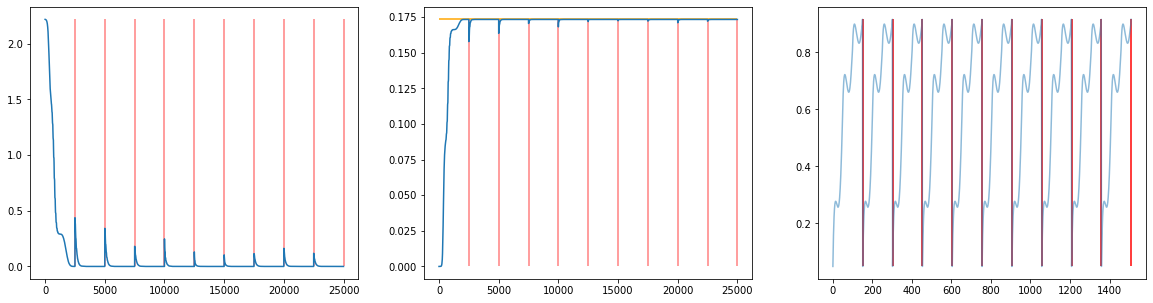

In [153]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,3,1)
ax1.plot(losses_all)
ax1.vlines(switch_times, 0,max(losses_all),color='red',alpha=0.5)

ax2 = plt.subplot(1,3,2)
ax2.plot(ev_all)
ax2.vlines(switch_times, min(ev_all), ev_pca, color='red',alpha=0.5)
ax2.hlines(ev_pca, 0, len(ev_all), color='orange')

ax3 = plt.subplot(1,3,3)
ax3.plot(r2_scores_all,alpha=0.5)
ax3.vlines(switch_times_output, min(r2_scores_all), max(r2_scores_all), color='red')

plt.show()


# Two layers regression

In [48]:
# W = np.random.randn(n_y,3)*1e-3
# W_r = np.random.randn(n_y, n_y)*1e-3

# lateral_inhibition=True

In [49]:
# losses = []
# ev_s = []

# η = 1e-1 # learning rate
# tol=1e-4
# epochs = 2

# # train first layer
# for _ in range(epochs):

#     y = W@I_ # [2,T]
#     y_r = y + (W_r@y if lateral_inhibition else 0)

#     # oja rule update
#     W += η*(y_r@I_.T - np.power(y_r.sum(1, keepdims=True), 2)*W)
#     if lateral_inhibition:
#         W_r += -η*(y_r@y_r.T)

#     _,S,_ = np.linalg.svd(v_pca@W.T)
#     gdist = np.arccos(np.clip(S,0,1)).mean() # Grassman distance

#     Z_ = W@I_ # projection on found PC
#     if lateral_inhibition:
#         Z_ = Z_ + W_r@Z_ # projection on found PC

#     ev = Z_.var(1).sum() # explained variance

#     losses.append(gdist)        
#     ev_s.append(ev)

#     if gdist < tol:
#         break


In [50]:
# losses = []
# ev_s = []

# η = 1e-1 # learning rate
# tol=1e-4
# epochs = 2

# train_finished = False
# # train first layer
# for _ in range(epochs):
#     for j in range(N):

#         I_t = I_[:,j:j+1]
#         y_t = W@I_t # [2,T]
#         y_t_r = y_t + (W_r@y_t if lateral_inhibition else 0)

#         # oja rule update
#         W += η*(y_t_r@I_t.T - np.power(y_t_r,2)*W)
#         if lateral_inhibition:
#             W_r += -η*(y_t_r@y_t_r.T)

#     #     w_ = W #gs_orthogonalization(W)
#         _,S,_ = np.linalg.svd(v_pca@W.T)
#         gdist = np.arccos(np.clip(S,0,1)).mean() # Grassman distance

#         Z_ = W@I_ # projection on found PC
#         if lateral_inhibition:
#             Z_ = Z_ + W_r@Z_ # projection on found PC

#         ev = Z_.var(1).sum() # explained variance

#         losses.append(gdist)        
#         ev_s.append(ev)

#         if gdist < tol or ev_pca-ev<tol:
#             train_finished=True
#             break
#     if train_finished:
#         break


In [51]:
v_pca@v_pca.T

array([[ 1.00000000e+00, -1.57527521e-16],
       [-1.57527521e-16,  1.00000000e+00]])

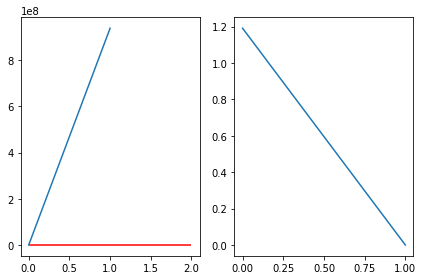

In [52]:
ax1= plt.subplot(1,2,1)
ax1.plot(ev_s)
ax1.hlines(ev_pca,0,len(ev_s), color='red')


ax2= plt.subplot(1,2,2)
ax2.plot(losses)
plt.tight_layout()

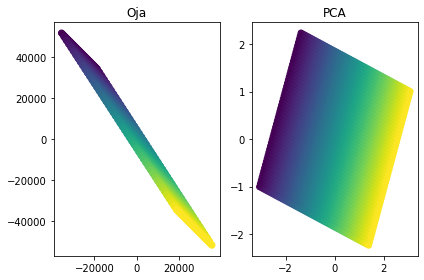

In [53]:
y_ = W@I_
y_r = y_ + W_r@y_

ax1= plt.subplot(1,2,1)
ax1.scatter(y_r[0], y_r[1], c=theta)
ax1.set_title('Oja')


ax2= plt.subplot(1,2,2)
ax2.scatter(Z_pca[0], Z_pca[1], c=theta)
ax2.set_title('PCA')

plt.tight_layout()


For Oja’s rule the $n_y$ weight vectors converge to span the same subspace as
these first $n_y$ eigenvectors, but do not find the eigenvector directions themselves

In [734]:
cross_val_score(LinearRegression(fit_intercept=False), y_r.T, theta, scoring=make_scorer(r2_score))

array([0.99679307, 0.99852725, 0.99879952, 0.99852725, 0.99679307])

In [735]:
ridge = LinearRegression(fit_intercept=False).fit(y_r.T, theta)
W_out_lr = ridge.coef_[None,:]

In [781]:
W_out = np.random.randn(1, n_y)*1e-3

r2_scores = []
η = 1e-1
wd = 1e-2
epochs = 100

for ep in range(epochs):
    for j in range(N_I):
        
        y_t_r = y_r[:,j:j+1]
        theta_t = theta[None,j:j+1]

        W_out += η*(theta_t@y_t_r.T - wd*W_out) # np.power(theta_t,2) 
#         W_out = W_out/np.linalg.norm(W_out)

        theta_pred = (W_out@y_r).flatten()
        r2_scores.append(r2_score(theta, theta_pred))

In [782]:
W_our_ls = (theta@y_r.T)@np.linalg.inv(y_r@y_r.T)

In [783]:
theta_pred_ls = W_our_ls@y_r

In [784]:
r2_score(theta, theta_pred_ls), r2_score(theta, theta_pred_lr), r2_score(theta, theta_pred)

(0.9987995198079231, 0.9987995198079231, 0.9704493592902494)

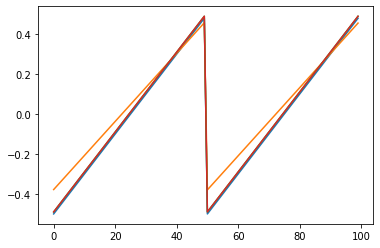

In [785]:
theta_pred_lr = (W_out_lr@y_r).flatten()
plt.plot(theta[:100])
plt.plot(theta_pred[:100])
plt.plot(theta_pred_lr[:100])
plt.plot(theta_pred_ls[:100])

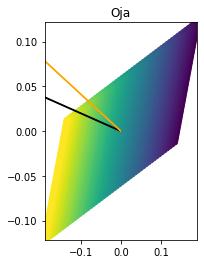

In [786]:
arr_mult = 100
dx,dy = W_out[0][0], W_out[0][1]

dx_r, dy_r = ridge.coef_

ax1= plt.subplot(1,2,1)
ax1.scatter(y_r[0], y_r[1], c=theta)
ax1.arrow(0,0,dx*arr_mult,dy*arr_mult)
ax1.arrow(0,0,dx_r,dy_r,color='orange')
ax1.set_title('Oja')

ax1.set_xlim(y_r[0].min(), y_r[0].max())
ax1.set_ylim(y_r[1].min(), y_r[1].max())
plt.show()

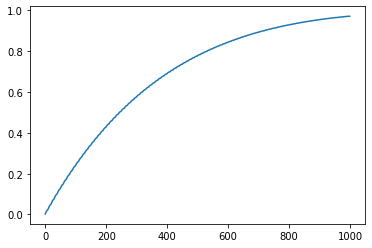

In [787]:
plt.plot(r2_scores)